##  convolutional neural networks model for kaggle's dogs vs. cats redux 
### uses keras 1.2.2, python 2.7, fast.ai's vgg and utils scripts
data prearranged into dog/cat subdirectories, validation set created, 
job run on floydhub 

In [1]:
# to show plots in the notebook
%matplotlib inline

In [2]:
# create results subdir in output (current working) directory
%mkdir results
%ls /output/
%ls /input/

command.sh              redux.ipynb  utils.pyc  vgg16bn.py
floyd-gpu.sh            results/     vgg16.py   vgg16bn.pyc
floyd_requirements.txt  utils.py     vgg16.pyc
results/  test/  train/  unzip/  valid/


In [3]:
from __future__ import division,print_function # for some Python 3 functionality
import theano
print(theano.__version__)

import keras
print(keras.__version__)

Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
Using Theano backend.


0.9.0
1.2.2


In [4]:
# fastai's convenience functions and vgg scripts
from utils import *
from vgg16 import Vgg16

### using a vgg convolutional neural network model pretrained for keras

In [5]:
# max batch size of 64 recommended
batch_size = 64

### finetuning and training the vgg model

In [6]:
# import vgg class
vgg = Vgg16()

# images reside in subdirectories; name = dog or cat category
batches = vgg.get_batches('/input/train', batch_size = batch_size)
val_batches = vgg.get_batches('/input/valid', batch_size = batch_size*2)

# finetune() keeps weights pretrained from ImageNet datasets
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.


In [7]:
# fit() fits the model parameters using training data
# can experiment with number of epochs to increase model accuracy
latest_weights_filename = None
num_epochs = 1 
for epoch in range(num_epochs):
    print("running epoch: %d" %epoch)
    vgg.fit(batches, val_batches, nb_epoch = 1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights('/output/results/'+latest_weights_filename)
print("completed %s fittings" % num_epochs)

running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 540s - loss: 0.1260 - acc: 0.9684 - val_loss: 0.0611 - val_acc: 0.9827
completed 1 fittings


In [8]:
# create test subdir with single unkown image class in floydhub output directory
%cd /output/
%mkdir -p test1/unknown

%cd /output/test1
%cp /input/test/*.jpg /output/test1/unknown

/output
/output/test1


### generating predictions on test set

In [9]:
batches, preds = vgg.test('/output/test1', batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [10]:
# vgg.test() generates two probabilities for every image based on dog/cat subdirectory order
# column one looks to be dogs, column two cats
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

[[  1.0000e+00   3.6786e-09]
 [  1.0000e+00   1.9803e-08]
 [  5.1444e-09   1.0000e+00]
 [  9.9997e-01   3.2225e-05]
 [  1.9700e-02   9.8030e-01]]
['unknown/10592.jpg', 'unknown/7217.jpg', 'unknown/3653.jpg', 'unknown/4382.jpg', 'unknown/2924.jpg']


In [11]:
len(preds)

12500

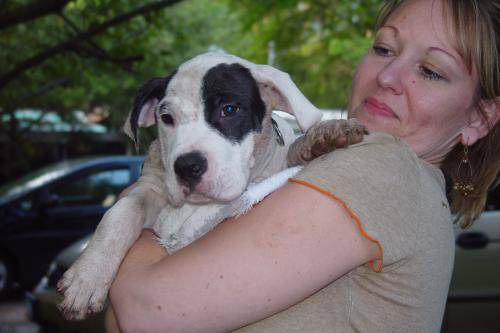

In [12]:
# verify the column ordering by viewing image
from PIL import Image
Image.open('/output/test1/'+filenames[2])

In [13]:
# save test result arrays
save_array('/output/results/'+'test_predictions.dat', preds)
save_array('/output/results/'+'filenames.dat', filenames)

### calculating predictions on the validation set to find correct/incorrect examples
keras's fit() function shows the accuracy after every run through the training set (epoch). validation set helps us detect overfitting. fast.ai teaches to try to overfit with first model as there are methods to reduce overfitting, which is less worry than underfitting

In [14]:
vgg.model.load_weights('/output/results/' + latest_weights_filename)

In [15]:
val_batches, probs = vgg.test('/input/valid', batch_size = batch_size)

Found 2200 images belonging to 2 classes.


In [16]:
filenames = val_batches.filenames

# labels are probability of being in class: {0,1}
expected_prob_labels = val_batches.classes
predicted_prob = probs[:,0]
predicted_prob_labels = np.round(1-predicted_prob)

In [17]:
from keras.preprocessing import image

# helper function from utils.py to plot images by index in the validation set 
def plots_idx(idx, titles = None):
    plots([image.load_img('/input/valid/'+filenames[i]) for i in idx], titles = titles)
    
# number of images to view for each task
n_view = 4

found 2162 correct labels


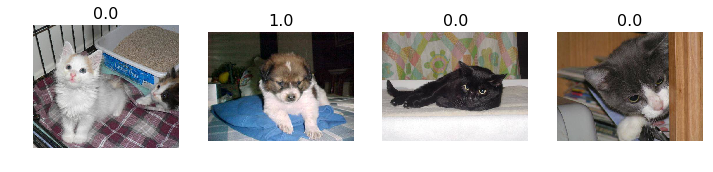

In [18]:
# a few correct labels at random
correct = np.where(predicted_prob_labels == expected_prob_labels)[0]
print("found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, predicted_prob_labels[idx])

found 38 incorrect labels


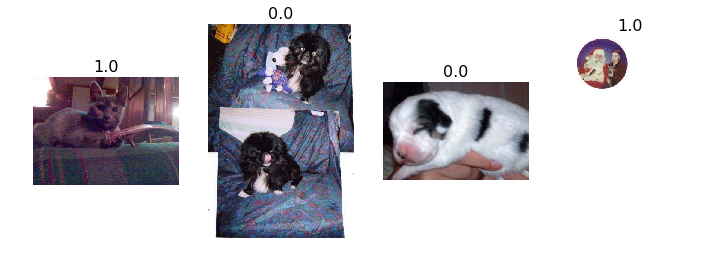

In [19]:
# a few incorrect
incorrect = np.where(predicted_prob_labels != expected_prob_labels)[0]
print("found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, predicted_prob_labels[idx])

#### measure model performance with confusion matrix of predicted/expected probabilities

[[1089   18]
 [  20 1073]]


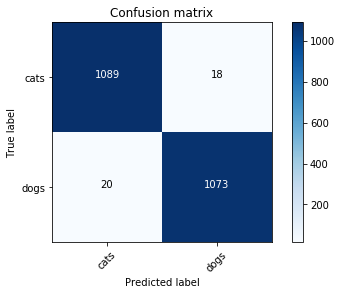

In [20]:
# generate matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected_prob_labels, predicted_prob_labels)

# plot 
plot_confusion_matrix(conf_matrix, val_batches.class_indices)
# number of TN, number of FP
# number of FN, number of TP 
# accuracy: 

### Kaggle submission

In [21]:
# load test predictions from file
preds = load_array('/output/results/'+'test_predictions.dat')
filenames = load_array('/output/results/'+'filenames.dat')

In [22]:
# grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [  3.6786e-09   1.9803e-08   1.0000e+00   3.2225e-05   9.8030e-01]
Mid Predictions: [ 0.5976  0.4052  0.5487  0.4207  0.4915  0.4305  0.5891  0.4428  0.5379  0.4043  0.5151  0.5236
  0.5318  0.4929  0.4768  0.4463  0.5862  0.5681  0.4573  0.5897  0.4286  0.4036  0.5081  0.4748
  0.4753  0.5739  0.4314  0.5272  0.4813  0.4858  0.5927  0.556   0.4199  0.537   0.5623  0.4337
  0.4125]
Edge Predictions: [ 1.  1.  1. ...,  1.  1.  1.]


In [23]:
# round down edge predictions to minimize log loss (kaggle's evaluation metric)
# log loss quantifies accuracy of classifier by heavily penalizing confident but false classifications
# swap all ones with 0.95 (reduces penalty for cats confidently classified as dogs) 
# swap all zeroes with 0.05 (reduces penalty for dogs confidently classified as cats)
isdog = isdog.clip(min = 0.05, max = 0.95)

In [24]:
# get image ids from test1/unknown subdir
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [25]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  1.0592e+04,   5.0000e-02],
       [  7.2170e+03,   5.0000e-02],
       [  3.6530e+03,   9.5000e-01],
       [  4.3820e+03,   5.0000e-02],
       [  2.9240e+03,   9.5000e-01]])

In [26]:
print(ids.shape, type(ids), isdog.shape, type(isdog))

(12500,) <type 'numpy.ndarray'> (12500,) <type 'numpy.ndarray'>


In [28]:
%mkdir submission
%cd submission
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

mkdir: cannot create directory ‘submission’: File exists
/output/test1/submission


In [29]:
from IPython.display import FileLink
FileLink(submission_file_name)

[Errno 2] No such file or directory: '$submission'
/output/test1/submission


/output/test1/submission/submission1.csv